 * `Imbort Libraries`

In [224]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from imblearn.over_sampling import SMOTE

from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import f_classif, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

* `Read Dataset`

In [225]:
DATA_PATH = os.path.join(os.getcwd(), '..', 'dataset', 'loan_approval_dataset.csv')
df = pd.read_csv(DATA_PATH)
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [226]:
df.drop(columns='loan_id',axis=1,inplace=True)

In [227]:
df.columns = df.columns.str.strip().str.replace(' ','_')

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   no_of_dependents          4269 non-null   int64 
 1   education                 4269 non-null   object
 2   self_employed             4269 non-null   object
 3   income_annum              4269 non-null   int64 
 4   loan_amount               4269 non-null   int64 
 5   loan_term                 4269 non-null   int64 
 6   cibil_score               4269 non-null   int64 
 7   residential_assets_value  4269 non-null   int64 
 8   commercial_assets_value   4269 non-null   int64 
 9   luxury_assets_value       4269 non-null   int64 
 10  bank_asset_value          4269 non-null   int64 
 11  loan_status               4269 non-null   object
dtypes: int64(9), object(3)
memory usage: 400.3+ KB


In [229]:
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07


* `EDA`

In [230]:
df.isna().sum()

no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [231]:
df.duplicated().sum()

np.int64(0)

In [232]:
df.dtypes

no_of_dependents             int64
education                   object
self_employed               object
income_annum                 int64
loan_amount                  int64
loan_term                    int64
cibil_score                  int64
residential_assets_value     int64
commercial_assets_value      int64
luxury_assets_value          int64
bank_asset_value             int64
loan_status                 object
dtype: object

Feature Engineering

In [233]:
# To combine the asset features
df['total_assets'] = df['residential_assets_value'] + df['commercial_assets_value'] + df['luxury_assets_value'] + df['bank_asset_value']

In [234]:
df['loan_to_income'] = df['loan_amount'] / df['income_annum']
df['loan_to_assets_ratio'] = df['loan_amount'] / df['total_assets'] + 1

In [235]:
df['education'].value_counts()

education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

In [236]:
df['self_employed'].value_counts()

self_employed
Yes    2150
No     2119
Name: count, dtype: int64

In [237]:
# Target Column
df['loan_status'].value_counts()

loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

In [238]:
# OH MY GAT THIS IS Imbalanced Data

* `Data VIZ & Handling Outlier`

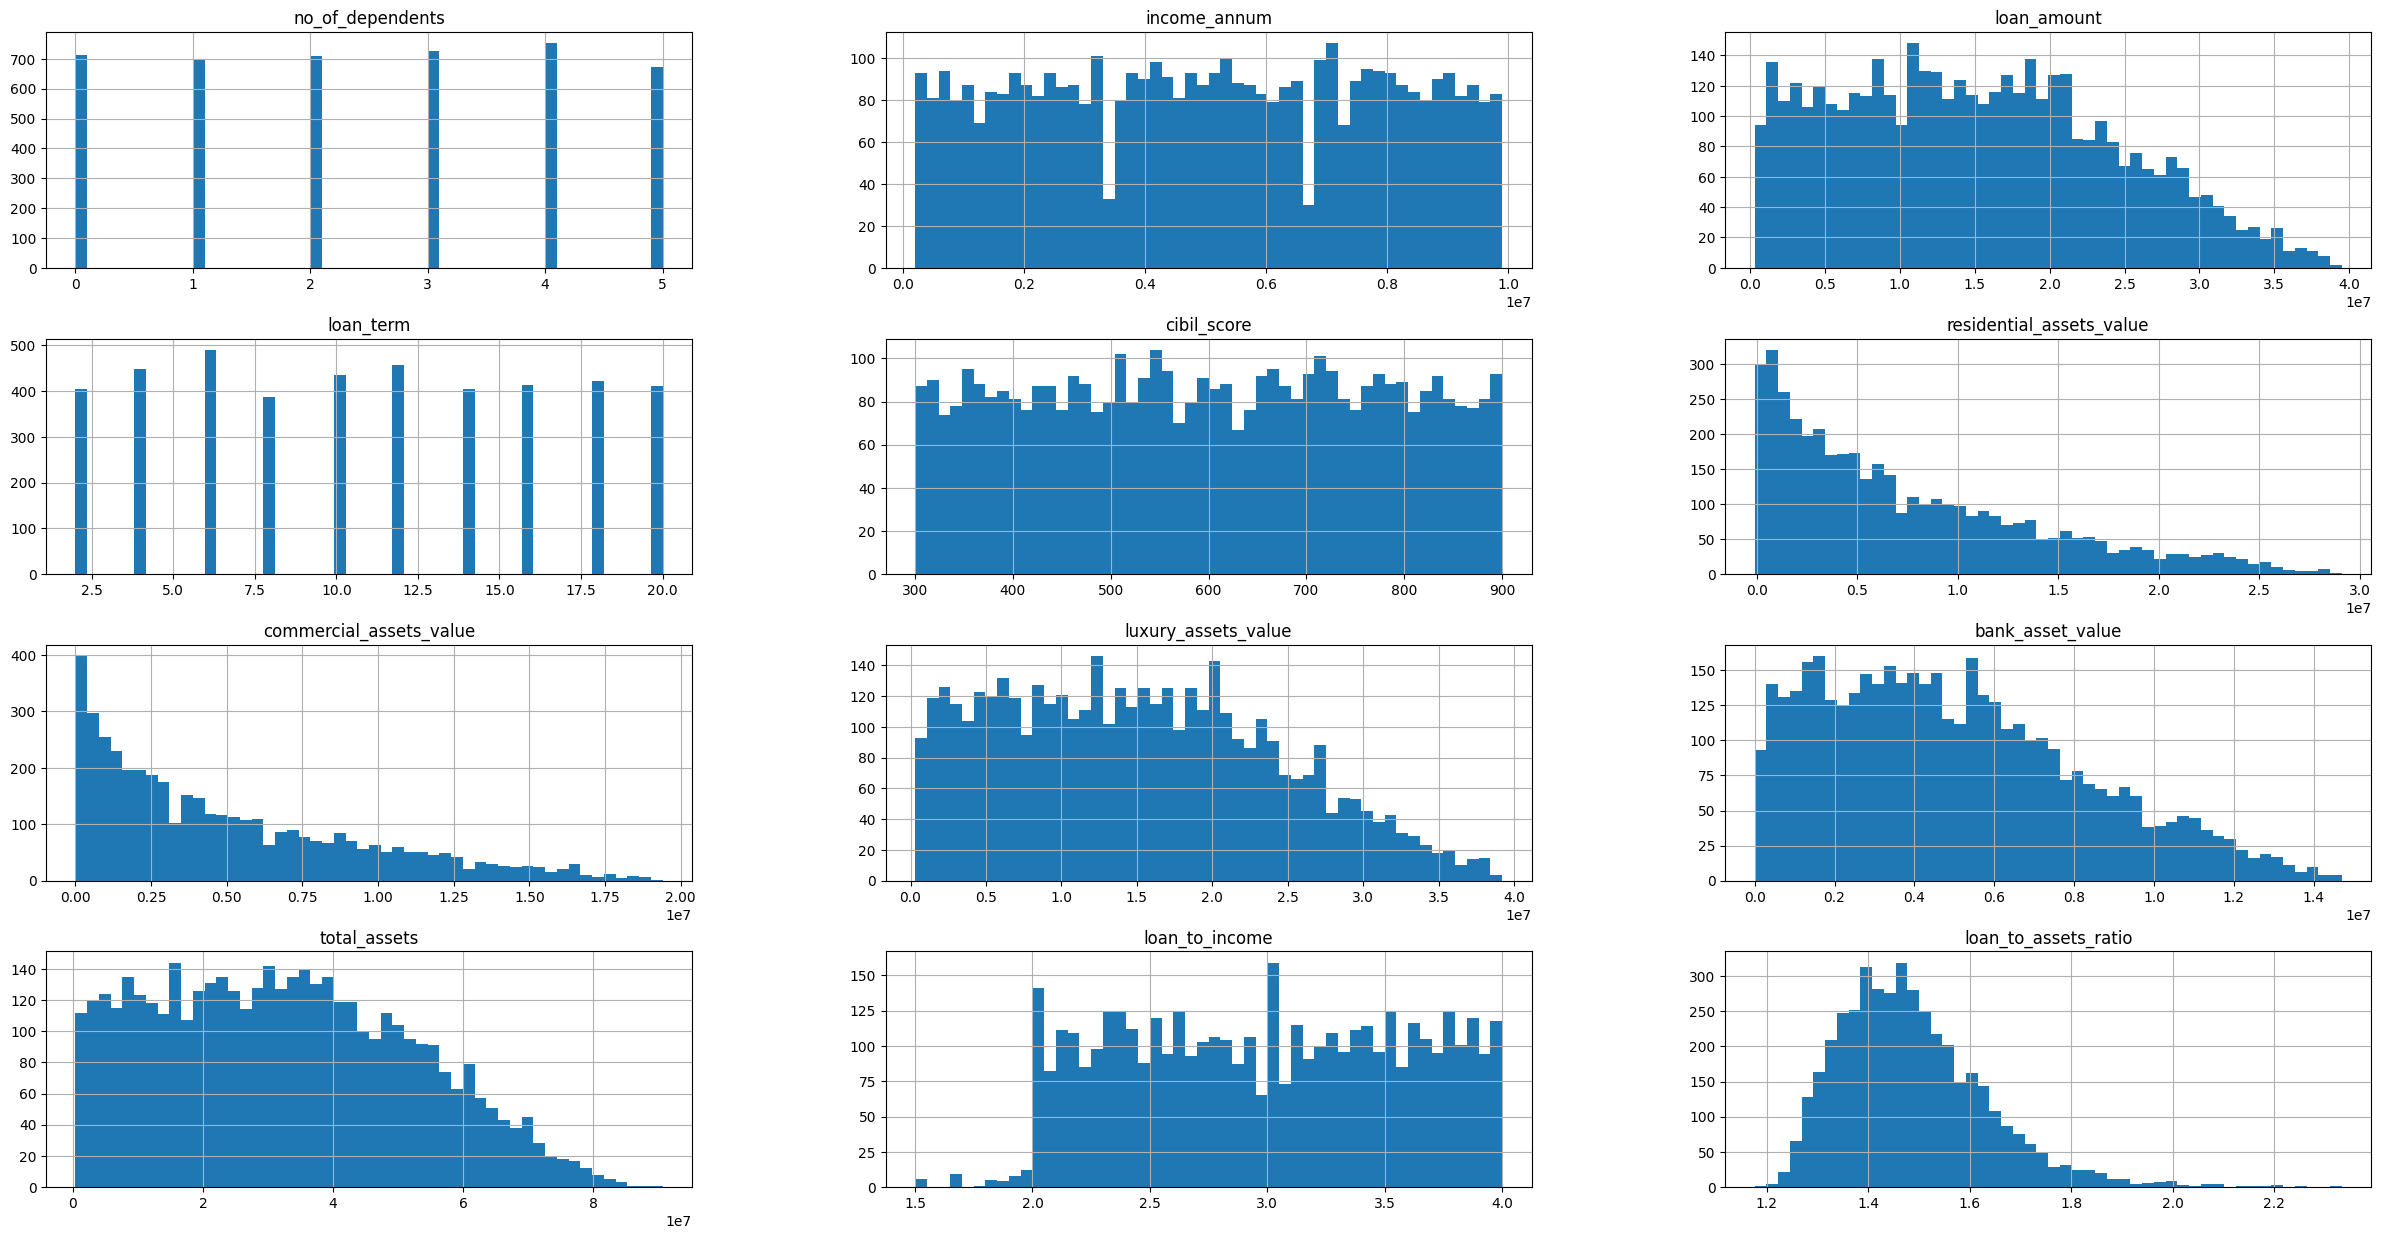

In [239]:
df.hist(bins=50,figsize=(30,15))
plt.show()

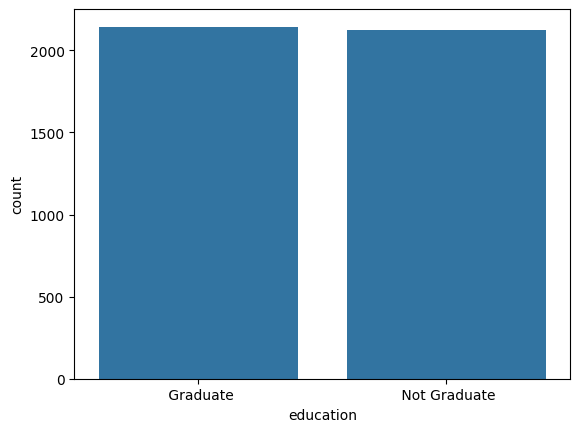

In [240]:
sns.countplot(data=df,x='education', order=df['education'].value_counts().index.tolist())
plt.show()

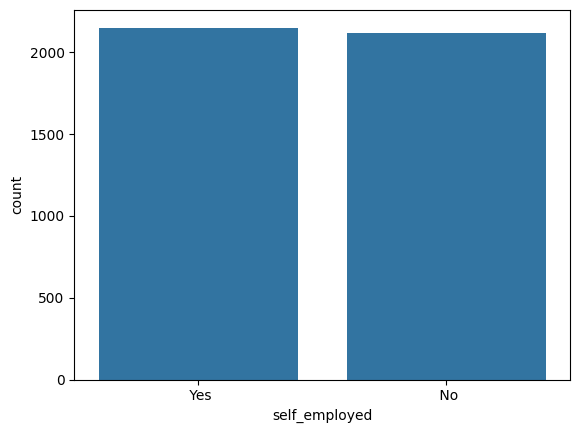

In [241]:
sns.countplot(data=df,x='self_employed', order=df['self_employed'].value_counts().index.tolist())
plt.show()

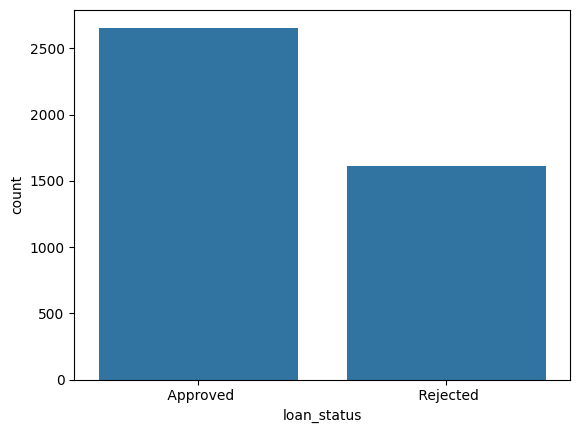

In [242]:
sns.countplot(data=df,x='loan_status');

In [243]:
df[['self_employed','income_annum']].groupby(by='self_employed')['income_annum'].mean()

self_employed
No     5.052430e+06
Yes    5.065721e+06
Name: income_annum, dtype: float64

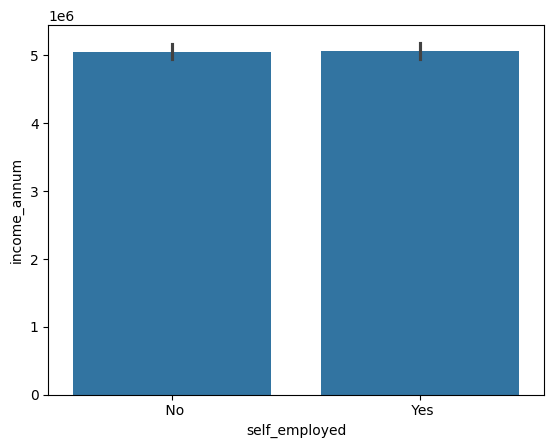

In [244]:
sns.barplot(data=df,x='self_employed',y='income_annum',estimator='mean');

In [245]:
df[['education','income_annum']].groupby(by='education')['income_annum'].mean()

education
Graduate        5.091604e+06
Not Graduate    5.026353e+06
Name: income_annum, dtype: float64

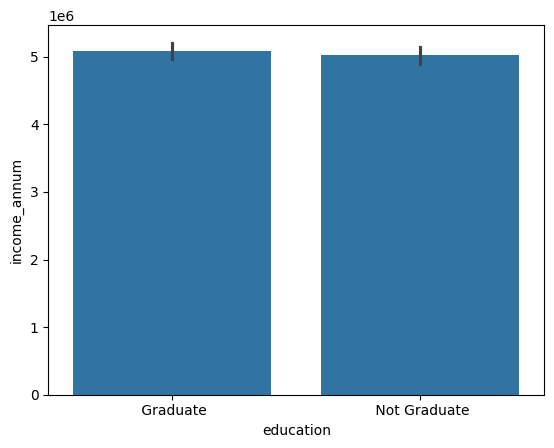

In [246]:
sns.barplot(data=df,x='education',y='income_annum',estimator='mean');

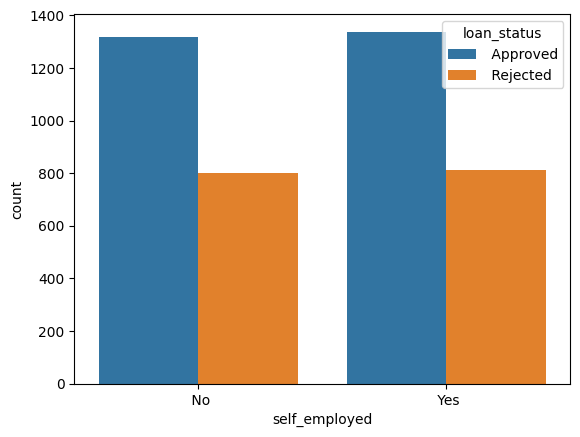

In [247]:
sns.countplot(data=df,x='self_employed',hue='loan_status')
plt.show()

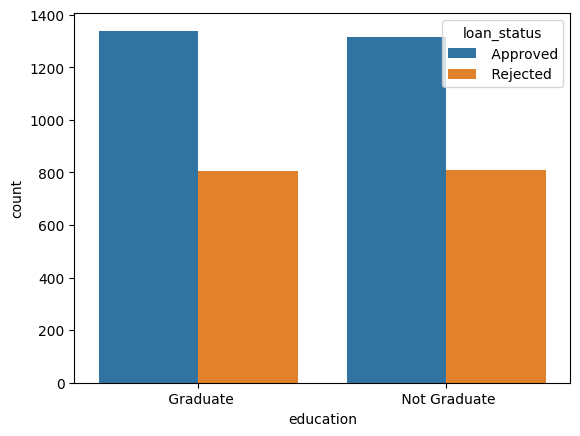

In [248]:
sns.countplot(data=df,x='education',hue='loan_status')
plt.show()

* `Split to train & test `


In [249]:
X = df.drop(columns='loan_status',axis=1)
y = df['loan_status']

In [250]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=True,stratify=y,random_state=42)

In [251]:
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('***'*10)
print('X_test.shape \t', X_test.shape)
print('y_test.shape \t', y_test.shape)

X_train.shape 	 (3415, 14)
y_train.shape 	 (3415,)
******************************
X_test.shape 	 (854, 14)
y_test.shape 	 (854,)


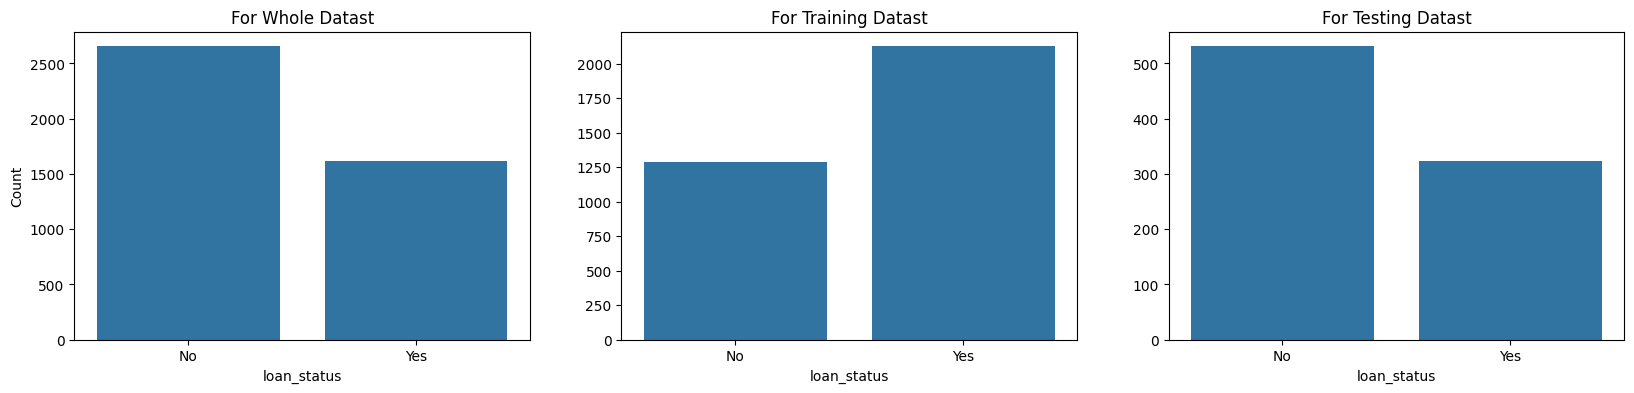

In [252]:
# plottting to check
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

# Whole dataset
plt.sca(ax[0])
sns.countplot(x=y)
plt.title('For Whole Datast')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# train
plt.sca(ax[1])
sns.countplot(x=y_train)
plt.title('For Training Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

# test
plt.sca(ax[2])
sns.countplot(x=y_test)
plt.title('For Testing Datast')
plt.ylabel('')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])
plt.show()

In [253]:
df.head(2)

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status,total_assets,loan_to_income,loan_to_assets_ratio
0,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved,50700000,3.114583,1.589744
1,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected,17000000,2.975610,1.717647


In [254]:
df.dtypes

no_of_dependents              int64
education                    object
self_employed                object
income_annum                  int64
loan_amount                   int64
loan_term                     int64
cibil_score                   int64
residential_assets_value      int64
commercial_assets_value       int64
luxury_assets_value           int64
bank_asset_value              int64
loan_status                  object
total_assets                  int64
loan_to_income              float64
loan_to_assets_ratio        float64
dtype: object

* `Feature Selection & Preporcessing`

In [255]:
num_cols = [
    'no_of_dependents',
    'income_annum',
    'loan_amount',
    'loan_term',
    'cibil_score',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value',
    'total_assets',
    'loan_to_income',
    'loan_to_assets_ratio'
]

categ_cols = ['education', 'self_employed']



In [256]:
# Numerical cols (num_cols) & Target cols --> ANOVA
_, p_val = f_classif(X=X_train[num_cols], y=y_train)
p_val   # All features p-value less than 0.05 --> Reject H0 --> There is an asscociation

array([4.74588626e-01, 6.73910751e-01, 1.51807172e-01, 5.06092407e-11,
       0.00000000e+00, 4.39776580e-01, 4.38728213e-01, 6.41884646e-01,
       9.49820957e-01, 7.55481542e-01, 3.60632382e-07, 2.87439279e-02])

In [257]:
_,p_val = chi2(X=OrdinalEncoder().fit_transform(X_train[categ_cols]),y=y_train)
p_val

array([0.88899926, 0.8440301 ])

In [258]:
#df.drop(columns=['no_of_dependents','residential_assets_value','commercial_assets_value','luxury_assets_value'],inplace=True)

In [259]:
for col in categ_cols:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)

In [260]:
# Pipeline

# Numerical: num_cols --> Imputing using median, and standardscaler
# Categorical: categ_cols ---> Imputing using mode, and OHE
# Ready_cols ---> Imputing mode


# For Numerical
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# For Categorical
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# For Ready cols


# Combine all
preprocessor = ColumnTransformer(transformers=[
    ('numerical', num_pipeline, num_cols),
    ('categorical', categ_pipeline, categ_cols)
    
])

# Apply to train and test
X_train_final = preprocessor.fit_transform(X_train)
X_test_final = preprocessor.transform(X_test)


In [261]:
la = LabelEncoder()
y_train = la.fit_transform(y_train)
y_test = la.transform(y_test)


In [262]:
X_train_final.shape , y_train.shape

((3415, 14), (3415,))

In [263]:
X_test_final.shape , y_test.shape

((854, 14), (854,))

In [264]:
print(categ_cols)


['education', 'self_employed']


* `Deal with Imbalanced Dataset`

In [265]:
vals_count = 1 - (np.bincount(y_train) / len(y_train))
vals_count = vals_count / sum(vals_count)
dict_weight = {}
for i in range(2):
    dict_weight[i] = vals_count[i]
    
dict_weight

{0: np.float64(0.37774524158125916), 1: np.float64(0.6222547584187409)}

In [266]:
over = SMOTE(k_neighbors=5,random_state=42,sampling_strategy=.8)
X_train_final_resampled , y_train_resampled = over.fit_resample(X_train_final,y_train)

In [267]:
MODEL_FOLDER_PATH = os.path.join(os.getcwd(),'..','models')
os.makedirs(MODEL_FOLDER_PATH,exist_ok=True)

In [268]:
joblib.dump(preprocessor,os.path.join(MODEL_FOLDER_PATH,'preprocessor.pkl'))

['c:\\Users\\Abdallah Samir\\Desktop\\loan_data\\notebooks\\..\\models\\preprocessor.pkl']

* `Building Models `
* `Using f1_score`

In [269]:
log_clf = LogisticRegression(C=1.5)
log_clf.fit(X_train_final,y_train)

y_train_predict_log = log_clf.predict(X_train_final)
y_test_predict_log = log_clf.predict(X_test_final)

score_train_log = f1_score(y_train,y_train_predict_log)
score_test_log = f1_score(y_test,y_test_predict_log)

print(f"The f1_score using logistic model for traning dataset is {score_train_log*100:.2f}")
print(f"The f1_score using logistic model for testing dataset is {score_test_log*100:.2f}")

The f1_score using logistic model for traning dataset is 87.96
The f1_score using logistic model for testing dataset is 89.03


In [270]:
log_clf = LogisticRegression(C=1.5,class_weight=dict_weight)
log_clf.fit(X_train_final,y_train)

y_train_predict_log = log_clf.predict(X_train_final)
y_test_predict_log = log_clf.predict(X_test_final)

score_train_log = f1_score(y_train,y_train_predict_log)
score_test_log = f1_score(y_test,y_test_predict_log)

print(f"The f1_score using logistic model for traning dataset  with class weights is {score_train_log*100:.2f}")
print(f"The f1_score using logistic model for testing dataset with class weights  is {score_test_log*100:.2f}")

The f1_score using logistic model for traning dataset  with class weights is 89.36
The f1_score using logistic model for testing dataset with class weights  is 91.41


In [271]:
log_clf = LogisticRegression(C=1.5,class_weight=dict_weight)
log_clf.fit(X_train_final_resampled,y_train_resampled)

y_train_predict_log = log_clf.predict(X_train_final)
y_test_predict_log = log_clf.predict(X_test_final)

score_train_log = f1_score(y_train,y_train_predict_log)
score_test_log = f1_score(y_test,y_test_predict_log)

print(f"The f1_score using logistic model for traning dataset  with SMOTE is {score_train_log*100:.2f}")
print(f"The f1_score using logistic model for testing dataset with SMOTE  is {score_test_log*100:.2f}")

The f1_score using logistic model for traning dataset  with SMOTE is 89.45
The f1_score using logistic model for testing dataset with SMOTE  is 92.17


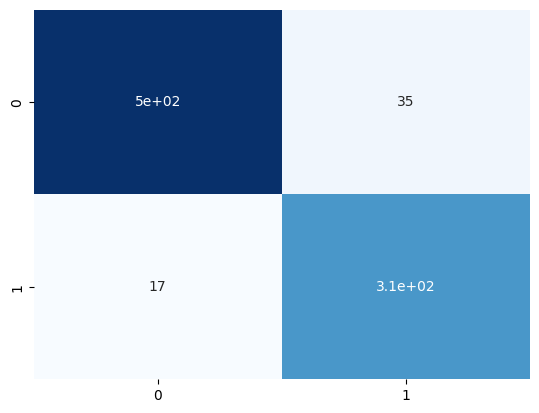

In [272]:
sns.heatmap(confusion_matrix(y_true=y_test,y_pred=y_test_predict_log),cmap='Blues',cbar=False,annot=True)
plt.show()

In [273]:
print(classification_report(y_true=y_test,y_pred=y_test_predict_log))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       531
           1       0.90      0.95      0.92       323

    accuracy                           0.94       854
   macro avg       0.93      0.94      0.94       854
weighted avg       0.94      0.94      0.94       854



In [274]:
joblib.dump(log_clf,os.path.join(MODEL_FOLDER_PATH,'logistic.pkl'))

['c:\\Users\\Abdallah Samir\\Desktop\\loan_data\\notebooks\\..\\models\\logistic.pkl']

* `RondomForest`

In [275]:
rf_clf = RandomForestClassifier(n_estimators=150,random_state=45,max_depth=5,class_weight=dict_weight)
rf_clf.fit(X_train_final,y_train)


y_train_predict_forest = rf_clf.predict(X_train_final)
y_test_predict_forest = rf_clf.predict(X_test_final)

score_train_forest = f1_score(y_train,y_train_predict_forest)
score_test_forest = f1_score(y_test,y_test_predict_forest)


print(f"The f1_score using RandomForest model for traning dataset  with SMOTE is {score_train_forest*100:.2f}")
print(f"The f1_score using RandomForest model for testing dataset with SMOTE  is {score_test_forest*100:.2f}")

The f1_score using RandomForest model for traning dataset  with SMOTE is 99.77
The f1_score using RandomForest model for testing dataset with SMOTE  is 99.69


In [276]:
# SMOTE
rf_clf = RandomForestClassifier(n_estimators=150,random_state=45,max_depth=5)
rf_clf.fit(X_train_final_resampled,y_train_resampled)


y_train_predict_forest = rf_clf.predict(X_train_final)
y_test_predict_forest = rf_clf.predict(X_test_final)

score_train_forest = f1_score(y_train,y_train_predict_forest)
score_test_forest = f1_score(y_test,y_test_predict_forest)


print(f"The f1_score using RandomForest model for traning dataset  with SMOTE is {score_train_forest*100:.2f}")
print(f"The f1_score using RandomForest model for testing dataset with SMOTE  is {score_test_forest*100:.2f}")

The f1_score using RandomForest model for traning dataset  with SMOTE is 100.00
The f1_score using RandomForest model for testing dataset with SMOTE  is 99.84


In [277]:
joblib.dump(rf_clf,os.path.join(MODEL_FOLDER_PATH,'randomforest.pkl'))

['c:\\Users\\Abdallah Samir\\Desktop\\loan_data\\notebooks\\..\\models\\randomforest.pkl']

* `XGBOOST`

In [278]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',max_depth=5,learning_rate=.1,n_estimators=150,random_state=45)
xgb_clf.fit(X_train_final_resampled,y_train_resampled)


y_train_predict_xgb = rf_clf.predict(X_train_final)
y_test_predict_xgb = rf_clf.predict(X_test_final)

score_train_xgb = f1_score(y_train,y_train_predict_xgb)
score_test_xgb = f1_score(y_test,y_test_predict_xgb)


print(f"The f1_score using RandomForest model for traning dataset  with SMOTE is {score_train_xgb*100:.2f}")
print(f"The f1_score using RandomForest model for testing dataset with SMOTE  is {score_test_xgb*100:.2f}")


The f1_score using RandomForest model for traning dataset  with SMOTE is 100.00
The f1_score using RandomForest model for testing dataset with SMOTE  is 99.84


In [279]:
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',max_depth=5,learning_rate=.1,n_estimators=150,random_state=45)
xgb_clf.fit(X_train_final,y_train)


y_train_predict_xgb = rf_clf.predict(X_train_final)
y_test_predict_xgb = rf_clf.predict(X_test_final)

score_train_xgb = f1_score(y_train,y_train_predict_xgb)
score_test_xgb = f1_score(y_test,y_test_predict_xgb)


print(f"The f1_score using RandomForest model for traning dataset  with SMOTE is {score_train_xgb*100:.2f}")
print(f"The f1_score using RandomForest model for testing dataset with SMOTE  is {score_test_xgb*100:.2f}")

The f1_score using RandomForest model for traning dataset  with SMOTE is 100.00
The f1_score using RandomForest model for testing dataset with SMOTE  is 99.84


In [280]:
joblib.dump(xgb_clf,os.path.join(MODEL_FOLDER_PATH,'xgb.pkl'))

['c:\\Users\\Abdallah Samir\\Desktop\\loan_data\\notebooks\\..\\models\\xgb.pkl']

In [281]:
import secrets

In [282]:
secrets.token_hex(16)

'a0e619e93e5e7e29c9e97e8e44fd9670'

In [283]:
df.describe()

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,total_assets,loan_to_income,loan_to_assets_ratio
count,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000,4269.000000
mean,2.498712,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,3.254877e+07,2.984807,1.486857
std,1.695910,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,1.950656e+07,0.595496,0.145554
min,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,4.000000e+05,1.500000,1.176471
25%,1.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,1.630000e+07,2.464286,1.382231
50%,3.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,3.150000e+07,3.000000,1.466667
75%,4.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,4.720000e+07,3.500000,1.565820
max,5.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,9.070000e+07,4.000000,2.333333
